# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 2: kNN and Linear Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>



<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to get you familiarized with k-Nearest Neighbors (kNN) and Linear Regression. We have learned how some aspects of dealing with data (loading in data files, scraping data from the web, visualizing data) and now we're moving to data modeling.

Specifically, we will: 
    
- Load in the Bikeshare dataset
- Do some basic exploratory data analysis (EDA) of the dataset
- Split it into a training and test dataset and understand why this is needed
- Learn to use kNN using the sklearn package (bonus: we will also look at writing the algorithm without sklearn)
- Learn to use the statsmodels and sklearn packages for Linear Regression.
- Learn about confidence intervals and how to extract them.

For this section we will be using the following packages:

In [3]:
#Matrices, Dataframe and Plotting Operations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Working with Dataframes

## Load in the Bikeshare dataset and perform EDA:

The task is to build a regression model for a bike share system to **predict the total number of bike rentals in a given day**, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the file 'bikeshare.csv'. Each row in these files contains 10 attributes describing a day and its weather.

**Description of variables**

- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent, or relative outdoor, or real feel temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)
- **count** (response variable i.e. total number of bike rentals on the day)


**Load the BikeShare dataset and drop the unnecessary columns**


In [62]:
bikeshare = pd.read_csv('https://raw.githubusercontent.com/Harvard-IACS/2019-CS109A/master/content/sections/section2/data/bikeshare.csv').drop(columns=['Unnamed: 0'])
print("Length of Dataset:",len(bikeshare))
display(bikeshare.head())
bikeshare.info()

Length of Dataset: 731


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       731 non-null    float64
 1   month        731 non-null    float64
 2   holiday      731 non-null    float64
 3   day_of_week  731 non-null    float64
 4   workingday   731 non-null    float64
 5   weather      731 non-null    float64
 6   temp         731 non-null    float64
 7   atemp        731 non-null    float64
 8   humidity     731 non-null    float64
 9   windspeed    731 non-null    float64
 10  count        731 non-null    float64
dtypes: float64(11)
memory usage: 62.9 KB


In [9]:
display(bikeshare.describe())

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,6.519836,0.028728,2.997264,0.683995,1.395349,16.229822,18.885089,62.789406,0.190486,4552.354309
std,1.110807,3.451913,0.167155,2.004787,0.465233,0.544894,11.531101,10.278475,14.242910,0.077498,2021.971365
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,0.000000,0.022392,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,6.000000,10.000000,52.000000,0.134950,3116.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,16.000000,20.000000,62.666700,0.180975,4575.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.020850,0.233214,6048.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,39.000000,42.000000,97.250000,0.507463,10045.000000


**We can also use the groupby function to look at mean stats aggregated by month**

In [20]:
# Your code here
bikeshare.groupby('month').mean()


,season,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
month,,,,,,,,,,
1.0,1.000000,0.048387,2.870968,0.645161,1.419355,-0.080645,4.145161,58.582827,0.206303,2498.306452
2.0,1.000000,0.035088,3.000000,0.684211,1.368421,3.912281,7.807018,56.746468,0.215684,2824.315789
3.0,1.354839,0.000000,3.096774,0.725806,1.451613,9.580645,13.080645,58.847503,0.222699,3822.241935
4.0,2.000000,0.033333,3.000000,0.666667,1.416667,14.583333,17.783333,58.806312,0.234482,4348.600000
5.0,2.000000,0.032258,2.903226,0.693548,1.403226,22.532258,24.661290,68.895831,0.182989,5268.790323
6.0,2.333333,0.000000,3.100000,0.716667,1.233333,28.150000,29.216667,57.580552,0.185420,5547.033333
7.0,3.000000,0.032258,2.935484,0.661290,1.193548,32.580645,33.338710,59.787632,0.166059,5563.677419
8.0,3.000000,0.000000,3.000000,0.741935,1.306452,29.629032,30.096774,63.773010,0.172918,5584.887097
9.0,3.266667,0.033333,3.050000,0.666667,1.500000,23.850000,25.466667,71.471437,0.165945,5653.316667


In [ ]:
# %load '../solutions/sol1.py'


**Let's plot the variation of count with month. Is  there a seasonal change?**

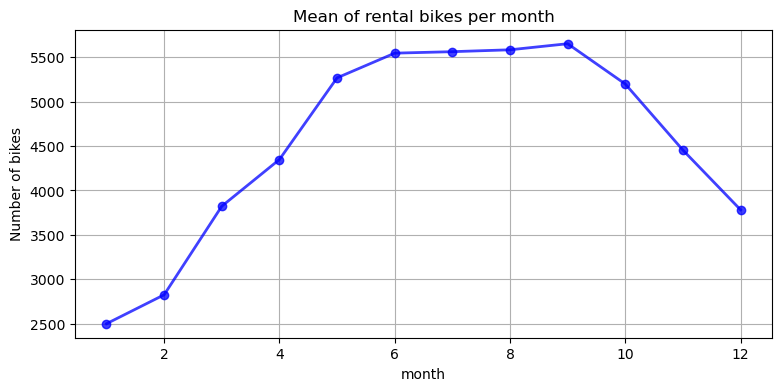

In [60]:
# Your code here
plt.figure(figsize=[9,4])
plt.plot(bikeshare.groupby('month').mean()['count'],  '-ob', linewidth='2', alpha = 0.75)

plt.title('Mean of rental bikes per month')
plt.xlabel('month')
plt.ylabel('Number of bikes')
plt.grid('on')
plt.show();


In [ ]:
# %load '../solutions/sol2.py'

**What is temp, a_temp, is there a difference? Let us plot them both**

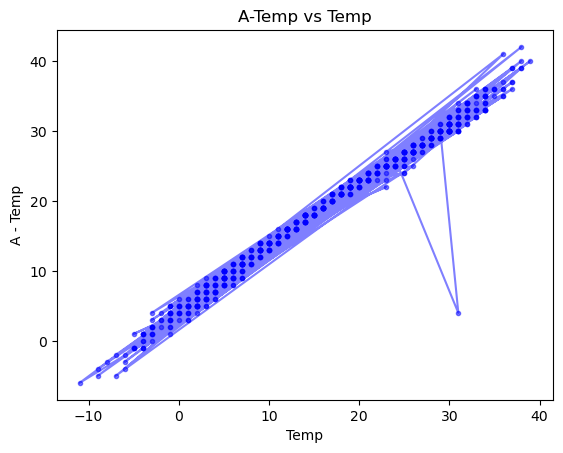

In [47]:
# Your code here
plt.plot(bikeshare['temp'],bikeshare['atemp'],'.-b', alpha =0.5)
plt.xlabel('Temp')
plt.ylabel('A - Temp')
plt.title('A-Temp vs Temp')
plt.show()


In [ ]:
# %load '../solutions/sol3.py'

**What did we do wrong here? Why does the plot look like this?**

**Sorting!** Whenever your plot makes zig-zag changes across the scale, it is because ```matplotlib``` is trying to connect the points *sequentially* from the top (using a line plot) and skipping across the scale when $x_{i+1}$ is lower than $x_{i}$. So let's sort.

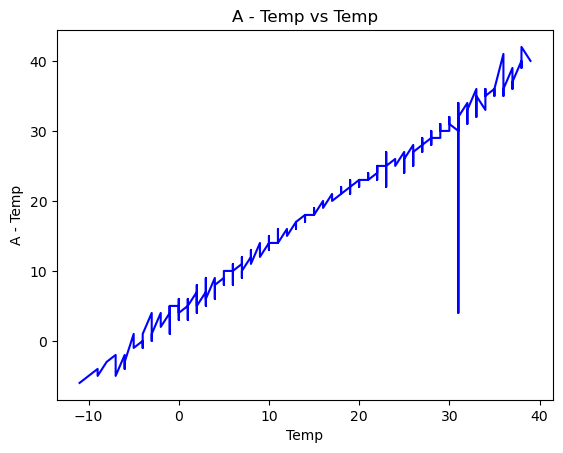

In [84]:
# Sorting
#bikeshare.sort_values('temp').head()

new = bikeshare.sort_values(['temp'])
plt.plot(new['temp'], new['atemp'],'-b',alpha=1)
plt.xlabel('Temp')
plt.ylabel('A - Temp')
plt.title('A - Temp vs Temp')
plt.show()

**It still looks weird, why?**

Let's have a closer look at the dataframe:

In [77]:
display(new.head(10))

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
176,1.0,1.0,0.0,6.0,0.0,1.0,-11.0,-6.0,40.0000,0.171970,981.0
367,1.0,1.0,0.0,1.0,1.0,1.0,-9.0,-4.0,49.1739,0.158330,1416.0
265,1.0,1.0,0.0,0.0,0.0,1.0,-9.0,-5.0,43.6522,0.246600,986.0
346,1.0,1.0,0.0,3.0,1.0,2.0,-8.0,-3.0,41.4583,0.184700,2368.0
612,1.0,2.0,0.0,3.0,1.0,2.0,-7.0,-2.0,49.4783,0.188839,1605.0
82,1.0,2.0,0.0,0.0,0.0,1.0,-7.0,-5.0,46.4583,0.409212,1529.0
475,1.0,2.0,0.0,4.0,1.0,1.0,-6.0,-2.0,43.7391,0.221935,1538.0
343,1.0,1.0,0.0,0.0,0.0,1.0,-6.0,-4.0,43.4167,0.361950,822.0
270,1.0,1.0,0.0,2.0,1.0,1.0,-6.0,-3.0,44.1250,0.365671,2236.0
457,1.0,1.0,0.0,5.0,1.0,1.0,-5.0,1.0,53.7826,0.126548,6079.0


There are multiple ```atemp``` values for each ```temp``` value, which if not sorted will bounce around at the same x-value. Thus, we need to sort both axes simultaneously.

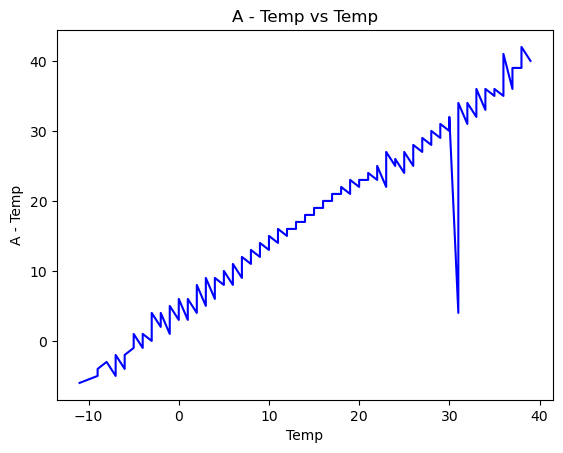

In [85]:
new = bikeshare.sort_values(['temp','atemp'])
plt.plot(new['temp'], new['atemp'],'-b')
plt.xlabel('Temp')
plt.ylabel('A - Temp')
plt.title('A - Temp vs Temp')
plt.show()

By plotting efficiently, we found an anomaly we would have otherwise overlooked. It looks like there is a problem with the data around ```temp greater than 30``` and ```atemp less than 10```.

**Show all rows in the dataframe where the temp is greater than 30 and the atemp is less than 10**

In [105]:
# Your code here
display(bikeshare[(bikeshare['temp']>30) & (bikeshare['atemp']<10)])



,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
188,3.0,8.0,0.0,5.0,1.0,1.0,31.0,4.0,57.0833,0.231354,7148.0


In [ ]:
# %load '../solutions/sol4.py'

Anomaly! ```atemp``` and ```temp``` are usually lineary related except at this one datapoint. Now, we get to make a judgement call as to whether we should keep the datapoint? We'll come back to this question after the lecture on Missing Data and Imputation. Worth a thought though.

In [113]:
bikeshare= bikeshare.drop([188])

KeyError: '[188] not found in axis'

We can now try what we wrote and we should end up with no rows in the dataframe where the temp is greater than 30 and the atemp is less than 10

In [114]:
# %load '../solutions/sol4.py'
display(bikeshare[(bikeshare['temp']>30) & (bikeshare['atemp']<10)])

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count


## Split up the data into a training set and a test set using the 'train_test_split' function from sklearn:

Having an idea of what the data looks like, we want to predict count. We will be breaking up the data into a **training** and a **testing** set. The **training** set will be used to train the model, while the **testing** set will be used to quantify how well our model does. The **testing** set is a way for us to ensure our model doesn't overfit our training data.

**Let us first create a function that will randomly split the data up into a 70-30 split, with 70% of the data going into the training set:**

In [116]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(bikeshare, test_size=0.30, random_state=42)

print("Length of Training set = ",len(train_data))
print("Length of Testing set  = ",len(test_data))

Length of Training set =  511
Length of Testing set  =  219


**Calculate the ratio of the number of points in the training set to the number of points in the testing set to see if we have split the data correctly**

In [ ]:
# Your code here



In [ ]:
# %load '../solutions/sol5.py'

# kNN Regression

![knn](../fig/knn_1.png)
![knn](../fig/knn_2.png)
![knn](../fig/knn_3.png)


## Using sklearn to implement kNN:

We will now use the [scikit learn (sklearn)](https://scikit-learn.org/stable/index.html) package to implement kNN. Then, we can fit the model and use various metrics to assess our accuracy.

**General sklearn model fitting code-structure :**

```
#Split Data into Train and Test Set
x_train, y_train = training_data.drop('Response_Variable', axis=1), training_data['Response_Variable']
x_test, y_test = test_data.drop('Response_Variable', axis=1), test_data['Response_Variable']

#Define Model
model = sklearn_model_name(hyper_parameter1 = value1, hyper_parameter2 = value2)

#Fit Model
model.fit(x_train, y_train)

#Get Prediction
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Evaluate Model
r2_train = model.score(y_train, y_pred_train)
r2_test = model.score(y_test, y_pred_test)

#Print Results
print("Score for Model (Training):", r2_train)
print("Score for Model (Testing) :", r2_test)
```

* Every model has a list of hyperparameters that can be set using sklearn for the specific problem. In practice it is advisable to cross-validate a list of values to find best model fit.

* ```model.fit``` calculates the parameters of your model corresponding to the training data and hyperparameters you provided.

* ```model.predict(X)``` is the standard method called to make the model predict values for a specific X. Depending on if you feed x_train or x_test, you will get a y_prediction_train or y_prediction_test respectively.

* Evaluation of model can vary according to the task at hand i.e. Regression or Classification. For Regression, $R^2$ Score is standard while for Classification, Accuracy (%) is standard.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Set kNN parameter:
k = 5

# Now we can fit the model, predict our variable of interest, and then evaluate our fit:
# First, we create the classifier object:
neighbors = KNeighborsRegressor(n_neighbors=k)

# Then, we fit the model using x_train as training data and y_train as target values:
neighbors.fit(train_data[['temp']], train_data['count'])

# Retreieve our predictions:
prediction_knn = neighbors.predict(test_data[['temp']])

# This returns the mean accuracy on the given test data and labels, or in other words, 
# the R squared value -- A constant model that always predicts the expected value of y, 
# disregarding the input features, would get a R^2 score of 1.
r2_train = neighbors.score(train_data[['temp']], train_data['count'])
r2_test = neighbors.score(test_data[['temp']], test_data['count'])
print("Length of Test Data:", len(test_data['count']))
print("R^2 Score of kNN on training set:", r2_train)
print("R^2 Score of kNN on testing set: ", r2_test)

In [ ]:
# SubPlots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axes[0].set_ylim([0,10000])
axes[0].plot(train_data['temp'], train_data['count'], 'o', label = 'Data' )

sorted_temp = train_data.sort_values(['temp'])
prediction_knn = neighbors.predict(sorted_temp[['temp']])

axes[0].plot(sorted_temp['temp'], prediction_knn, '*-', label = 'Prediction')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('# of Rides')
axes[0].set_title("Temp vs Count kNN Regression Training Set (k={})".format(k))
axes[0].legend()

axes[1].set_ylim([0,10000])
axes[1].plot(test_data['temp'], test_data['count'],'o', label = 'Data' )#, '*')

sorted_temp = test_data.sort_values(['temp'])
prediction_knn = neighbors.predict(sorted_temp[['temp']])

axes[1].plot(sorted_temp['temp'], prediction_knn, '*-', label = 'Prediction')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('# of Rides')
axes[1].set_title("Temp vs Count kNN Regression Test Set (k={})".format(k))
axes[1].legend()

fig.suptitle("Bike Rides");

# Linear Regression

![linear regression](../fig/linear_regression.png)

We just went over the kNN prediction method. Now, we will fit the same data with Linear Regression model. We will use a the same training/testing dataset as before and create our linear regression objects.

In [ ]:
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import statsmodels.api as sm

#Split Data into X,Y
x_train, y_train = train_data['temp'], train_data['count']
x_test, y_test = test_data['temp'], test_data['count']

#Add constant
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)

**Fit a Linear Regression (OLS) model using statsmodels and print out the coefficients of `temp` and `const`**

*Hint*: StatsModels use a Y followed by X structure while feeding data in contrast to sklearn that uses X followed by Y.

Give the name *results* to your fit model

In [ ]:
# Your code here



In [ ]:
# %load '../solutions/sol6.py'


In [ ]:
# Plotting our model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

axes[0].plot(x_train, y_train, 'o')
sorted_temp = train_data.sort_values(['temp'])
prediction_lr = results.predict(sm.add_constant(sorted_temp[['temp']]))
axes[0].plot(sorted_temp['temp'], prediction_lr, '*-', label = 'Prediction')
axes[0].set_title('Temp vs Count Linear Regression for Training Set')

axes[1].plot(x_test, y_test, 'o')
sorted_temp = test_data.sort_values(['temp'])
prediction_lr = results.predict(sm.add_constant(sorted_temp[['temp']]))
axes[1].plot(sorted_temp['temp'], prediction_lr, '*-', label = 'Prediction')
axes[1].set_title('Temp vs Count Linear Regression for Test Set')

for i, ax in enumerate(axes):
    ax.set_ylim(0,10000)
    ax.set_xlabel('Temperature')
    ax.set_ylabel('# of Rides')
    ax.legend()

In [ ]:
# Metrics, Performance Evaluation and Helpful functions

from sklearn import metrics

# To compute the mean squared error (notice that we are now using the TEST set):
print("R^2 Score for Linear Regression (Training):", metrics.r2_score(y_train, results.predict(x_train_ca)))
print("R^2 Score for Linear Regression (Testing) :", metrics.r2_score(y_test, results.predict(x_test_ca)))

**Check out `results.summary()` and pay close attention to the table that shows up**

In [ ]:
results.summary()

### Confidence Intervals

In Data Science, a confidence interval (CI) is a type of interval estimate, computed from the statistics of the observed data, that might contain the true value of an unknown population parameter. Simply speaking, a Confidence Interval is a range of values we are fairly sure our true value lies in. 

It is important to remind ourselves here that Confidence Intervals belong to a parameter and not a statistic. Thus, they represent the window in which the true value exists for the entire population when all we have is a sample.

![ci](../fig/confidence_intervals.png)

**See if you can implement a 95% confidence interval using statsmodels**

In [ ]:
# Your code here

In [ ]:
# %load '../solutions/sol7.py'

In the above block of code, ```results.conf_int(alpha=thresh)``` returns a dataframe with columns 0 and 1. We explained Confidence Intervals above where because we assume normal symetric distribution of data, the 95% Confidence Interval means there's 2.5% chance of the true value lying below the values in Column 0 and 2.5% chance of the true value lying above Column 1. 

----------------
### End of Standard Section
---------------

## Extra: Train-Test Split using a mask

In [ ]:
#Function to Split data into Train and Test Set
def split_data(data):
    
    #Calculate Length of Dataset
    length = len(data)
    
    #Define Split
    split = 0.7
    
    #Set a random Seed For Shuffling
    np.random.seed(9001)
    
    #Generate a Mask with a X:Y Split
    mask = np.random.rand(length) < split
    
    #Separate train and test data
    data_train = data[mask]
    data_test = data[~mask]
    
    #Return Separately
    return data_train, data_test

In [ ]:
#Split data using defined function
train_data_manual, test_data_manual = split_data(bikeshare)
print("Length of Training set:",len(train_data_manual))
print("Length of Testing set:",len(test_data_manual))

In [ ]:
## Check that the ratio between test and train sets is right
test_data_manual.shape[0]/(test_data_manual.shape[0]+train_data_manual.shape[0])

## Extra: Implementing the kNN Algorithm by hand

To really understand how the kNN algorithm works, it helps to go through the algorithm line by line in code.

In [ ]:
#kNN Algorithm
def knn_algorithm(train, test, k):
    
    #Create any empty list to store our predictions in
    predictions = []
    
    #Separate the response and predictor variables from training and test set:
    train_x = train['temp']
    train_y = train['count']
    test_x  = test['temp']
    test_y  = test['count']
    
    for i, ele in enumerate(test_x):
        
        #For each test point, store the distance between all training points and test point
        distances = pd.DataFrame((train_x.values - ele)**2 , index=train.index)
        distances.columns =['dist']
        
        #display(distances)
        #Then, we sum across the columns per row to obtain the Euclidean distance squared
        ##distances = vec_distances.sum(axis = 1)
        
        #Sort the distances to training points (in ascending order) and take first k points
        nearest_k = distances.sort_values(by='dist').iloc[:k]
        
        #For simplicity, we omitted the square rooting of the Euclidean distance because the
        #square root function preserves order. 
        
        #Take the mean of the y-values of training set corresponding to the nearest k points
        k_mean = train_y[nearest_k.index].mean()
        
        #Add on the mean to our predicted y-value list
        predictions.append(k_mean)
    
    #Create a dataframe with the x-values from test and predicted y-values  
    predict = test.copy()  
    predict['predicted_count'] = pd.Series(predictions, index=test.index)
    
    return predict

Now to run the algorithm on our dataset with $k = 5$:

In [ ]:
#Run the kNN function 

k = 5
predicted_knn = knn_algorithm(train_data, test_data, k)
predicted_knn.head()

We want to have a way to evaluate our predictions from the kNN algorithm with $k=5$. One way is to compute the $R^2$ coefficient. Let's create a function for that:

In [ ]:
#Test predictions in comparison to true value of test set
def evaluate(predicted, true):
    
    #Find the squared error:
    squared_error = (predicted['predicted_count'] - true['count'])**2
    
    #Finding the mean squared error:
    error_var = squared_error.sum()
    sample_var = ((true['count'] - true['count'].mean())**2).sum()
    r = (1 - (error_var / sample_var))
    return r

Then let's apply this function to our predictions:

In [ ]:
print("Length of Test Data:",len(test_data))
print("R^2 Score of kNN test:", evaluate(predicted_knn, test_data))

In [ ]:
predicted_knn_train = knn_algorithm(test_data, train_data, k)
print("R^2 Score of kNN train:", evaluate(predicted_knn_train, train_data))

## Extra: Computing different performance metrics by hand

Now, we will compute metrics that can be used to assess fit.

**Note: sklearn.metrics is class of functions that consists of all the metrics we care about to evaluate our models. While it is not hard to implement them yourself, it is helpful to go through http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.**

In [ ]:
model = sm.OLS(y_train, x_train_ca)
results = model.fit()

#Find the squared error:
y_pred_train = results.predict(x_train_ca)
squared_error_train = (y_pred_train - y_train)**2

 #Finding the mean squared error:
error_var_train = squared_error_train.mean()
sample_var_train = ((y_train - y_train.mean())**2).mean()

y_pred_test = results.predict(x_test_ca)
squared_error_test = (y_pred_test - y_test)**2

 #Finding the mean squared error:
error_var_test = squared_error_test.mean()

sample_var_test = ((y_test - y_test.mean())**2).mean()

print(error_var_train, sample_var_train, 1 - error_var_train/sample_var_train)
print(error_var_test, sample_var_test, 1 - error_var_test/sample_var_test)

---